In [1]:
#  Smart Portfolio Optimizer – Phase 1 to Phase 4 (No Optimization)

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [3]:
#  Phase 1: Data Collection
# -----------------------------
tickers = ['SPY', 'QQQ', 'TLT', 'IAU', 'EFA']
data = yf.download(tickers, start='2020-01-01', end='2024-12-31', auto_adjust=True)
adj_close = data['Close']
adj_close.to_csv("etf_prices.csv")

[*********************100%***********************]  5 of 5 completed


In [5]:
#  Phase 2: Metric Computation
# -----------------------------
adj_close = pd.read_csv("etf_prices.csv", index_col=0, parse_dates=True)
daily_returns = adj_close.pct_change().dropna()


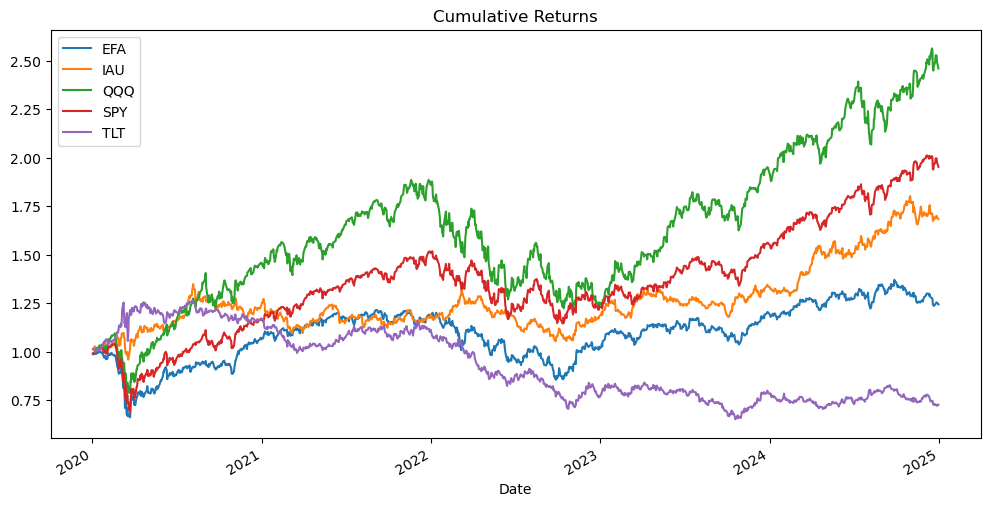

In [7]:
# Cumulative Returns
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.plot(figsize=(12, 6), title="Cumulative Returns")
plt.show()

In [9]:
# Volatility (Annualized)
volatility = daily_returns.std() * np.sqrt(252)
print("\nAnnual Volatility:\n", volatility)


Annual Volatility:
 EFA    0.199240
IAU    0.154927
QQQ    0.256547
SPY    0.210048
TLT    0.179695
dtype: float64


In [11]:
# Sharpe Ratio
rf_daily = 0.025 / 252
sharpe_ratio = ((daily_returns.mean() - rf_daily) / daily_returns.std()) * np.sqrt(252)
print("\nSharpe Ratio:\n", sharpe_ratio)


Sharpe Ratio:
 EFA    0.195515
IAU    0.591609
QQQ    0.735345
SPY    0.626012
TLT   -0.403642
dtype: float64


In [13]:
# Max Drawdown
cumulative = (1 + daily_returns).cumprod()
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print("\nMax Drawdown:\n", max_drawdown)


Max Drawdown:
 EFA   -0.339301
IAU   -0.218163
QQQ   -0.351187
SPY   -0.337173
TLT   -0.483511
dtype: float64


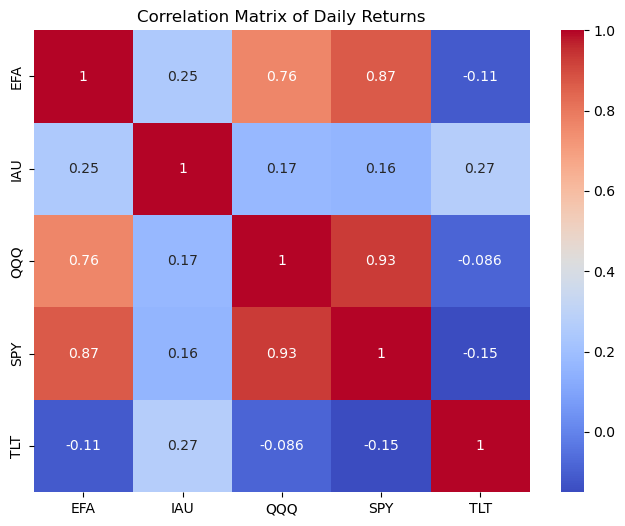

In [15]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(daily_returns.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

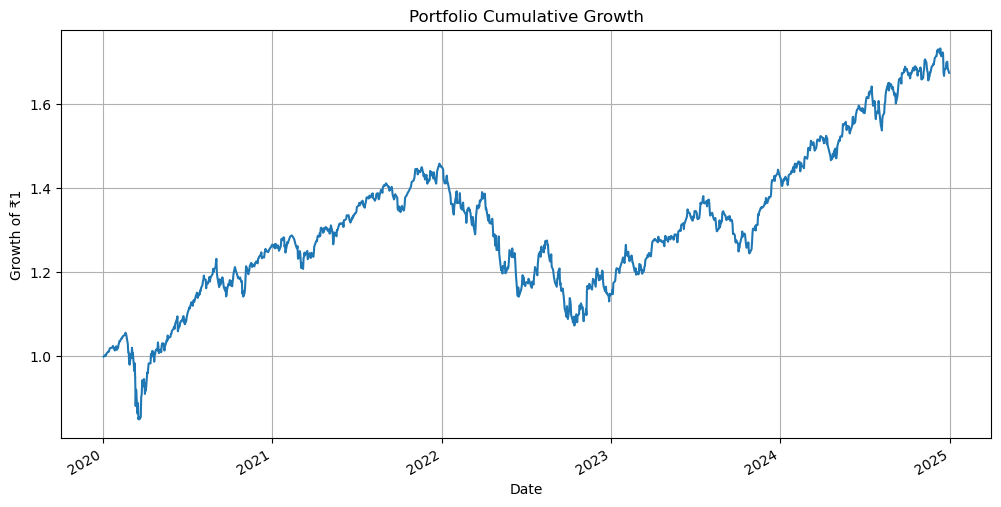


Portfolio Metrics:
Annualized Volatility: 14.96%
Sharpe Ratio: 0.600
Max Drawdown: -26.43%


In [17]:
# 📈 Phase 3: Portfolio Construction
# -----------------------------
weights = {
    'SPY': 0.30,
    'QQQ': 0.25,
    'TLT': 0.20,
    'IAU': 0.15,
    'EFA': 0.10
}

etfs = list(weights.keys())
weight_array = np.array(list(weights.values()))

portfolio_returns = daily_returns[etfs].dot(weight_array)
cumulative_portfolio = (1 + portfolio_returns).cumprod()

cumulative_portfolio.plot(title="Portfolio Cumulative Growth", figsize=(12, 6))
plt.ylabel("Growth of ₹1")
plt.grid(True)
plt.show()

portfolio_vol = portfolio_returns.std() * np.sqrt(252)
portfolio_sharpe = ((portfolio_returns.mean() - rf_daily) / portfolio_returns.std()) * np.sqrt(252)
portfolio_drawdown = ((1 + portfolio_returns).cumprod() / (1 + portfolio_returns).cumprod().cummax()) - 1
portfolio_max_drawdown = portfolio_drawdown.min()

print("\nPortfolio Metrics:")
print(f"Annualized Volatility: {portfolio_vol:.2%}")
print(f"Sharpe Ratio: {portfolio_sharpe:.3f}")
print(f"Max Drawdown: {portfolio_max_drawdown:.2%}")

In [19]:
# 🗂️ Phase 4: SQL Storage
# -----------------------------
conn = sqlite3.connect("portfolio.db")

# Save Weights
df_weights = pd.DataFrame.from_dict(weights, orient='index', columns=['weight'])
df_weights.index.name = 'ticker'
df_weights.to_sql("etf_weights", conn, if_exists="replace")

# Save Returns
portfolio_df = pd.DataFrame({
    "daily_return": portfolio_returns,
    "cumulative_growth": cumulative_portfolio
})
portfolio_df.to_sql("portfolio_returns", conn, if_exists="replace")

# Save Metrics
metrics = {
    "volatility": portfolio_vol,
    "sharpe_ratio": portfolio_sharpe,
    "max_drawdown": portfolio_max_drawdown
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['value'])
metrics_df.index.name = 'metric'
metrics_df.to_sql("portfolio_metrics", conn, if_exists="replace")

conn.close()


 Sharpe Ratio Optimization using

In [27]:
from scipy.optimize import minimize

# Subset of returns for the selected ETFs
returns = daily_returns[etfs]

# Function to calculate portfolio metrics
def portfolio_performance(weights):
    port_return = np.sum(returns.mean() * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe = (port_return - 0.025) / port_volatility
    return port_return, port_volatility, sharpe

# Function to minimize (we want to maximize Sharpe → minimize -Sharpe)
def neg_sharpe(weights):
    return -portfolio_performance(weights)[2]

# Constraints: weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds for each weight: between 0 and 1
bounds = tuple((0, 1) for _ in etfs)

# Initial guess: equal weights
initial_weights = len(etfs) * [1. / len(etfs)]

# Run optimizer
optimized = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract results
opt_weights = optimized.x
opt_return, opt_vol, opt_sharpe = portfolio_performance(opt_weights)

# Display results
print("\n Optimized Weights (Sharpe-Maximizing):")
for ticker, weight in zip(etfs, opt_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\n Optimized Annual Return: {opt_return:.2%}")
print(f" Optimized Volatility: {opt_vol:.2%}")
print(f" Optimized Sharpe Ratio: {opt_sharpe:.3f}")



 Optimized Weights (Sharpe-Maximizing):
SPY: 0.00%
QQQ: 45.09%
TLT: 0.00%
IAU: 54.91%
EFA: 0.00%

 Optimized Annual Return: 16.04%
 Optimized Volatility: 15.48%
 Optimized Sharpe Ratio: 0.875
